Hackaton: Urban Air Pollution Challenge 
=============================================
Edimer David Jaramillo   
Abril de 2020

## Instalando y cargando bibliotecas

In [0]:
install.packages("h2o", dependencies = TRUE)
library(tidyverse)
library(h2o)

## Importando datos

In [0]:
load("/content/nuevo1_test.Rdata")
load("/content/nuevo1_train.Rdata")

## Modelo XGBoost

In [33]:
# Iniciando h2o
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# Train y Test h2o
df_train <- df_train2 %>% 
  select(-c(1, 2, 3)) %>%
  mutate(target = log(target))

# Datos h2o
datos_h2o <- as.h2o(x = df_train, destination_frame = "datos_h2o")

particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.7, 0.20),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_H2O")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_H2O")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_H2O")

# Se define la variable respuesta y los predictores.
var_respuesta <- "target"

# Para este modelo se emplean todos los predictores disponibles.
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)

# Modelo XGB h2o
xgb <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb_model_3"
                  ,stopping_rounds = 5
                  ,stopping_metric = "RMSE"
                  ,distribution = "gaussian"
                  ,score_tree_interval = 1
                  ,learn_rate=0.01
                  ,ntrees=500
                  ,subsample = 0.9
                  ,colsample_bytree = 0.9
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 0.0
                  ,max_runtime_secs = 3600
                  ,nfolds = 10
                  ,seed = 123)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         47 minutes 34 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_root_ybq511 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   9.81 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 

  |======================================================================| 100%


Warning message in .h2o.processResponseWarnings(res):
“Dropping bad and constant columns: [day_week, month_date, Weekend].
”


  |======================================================================| 100%


In [34]:
xgb

Model Details:

H2ORegressionModel: xgboost
Model ID:  xgb_model_3 
Model Summary: 
  number_of_trees
1             420


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  0.2863848
RMSE:  0.5351494
MAE:  0.4114956
RMSLE:  0.1287501
Mean Residual Deviance :  0.2863848


H2ORegressionMetrics: xgboost
** Reported on validation data. **

MSE:  0.3305988
RMSE:  0.5749772
MAE:  0.4451219
RMSLE:  0.1336554
Mean Residual Deviance :  0.3305988


H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.3364044
RMSE:  0.5800038
MAE:  0.4462566
RMSLE:  0.1386725
Mean Residual Deviance :  0.3364044


Cross-Validation Metrics Summary: 
                             mean           sd cv_1_valid cv_2_valid cv_3_valid
mae                     0.4461823  0.012621825  0.4293004 0.45519575 0.45773137
mean_residual_deviance  0.3363092  0.020227265 0.30925724 0.344344

## Predicciones

In [40]:
# ============================= Predicciones ====================================== #

# Train
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Train)
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Submission)
predichos_subm <- h2o.predict(xgb, as.h2o(df_test2)) %>%
  as.data.frame() %>% pull(predict) %>% exp()
df_test2 %>% 
  select(`Place_ID X Date`) %>% 
  mutate(target = predichos_subm) ->
  subm5

# Exportando predicciones
write.csv(subm5, file = "subm5.csv", row.names = FALSE)

RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target)))
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


data,RMSE
<fct>,<dbl>
Train,0.5351494
Test,0.6053664


  |======================================================================| 100%


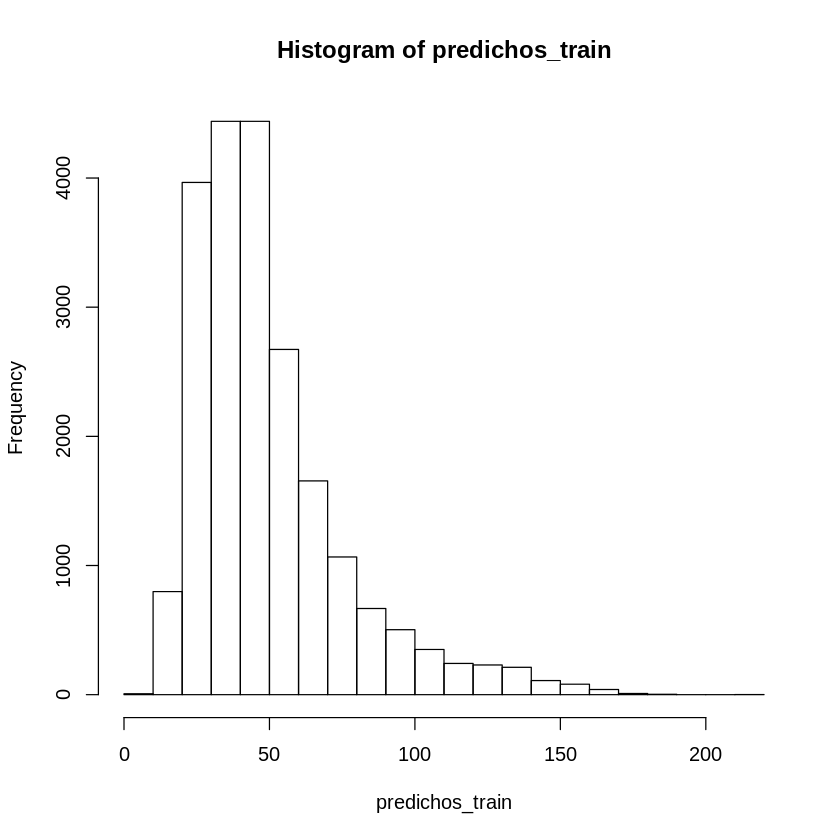

In [37]:
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict) %>% exp()
hist(predichos_train)

  |======================================================================| 100%


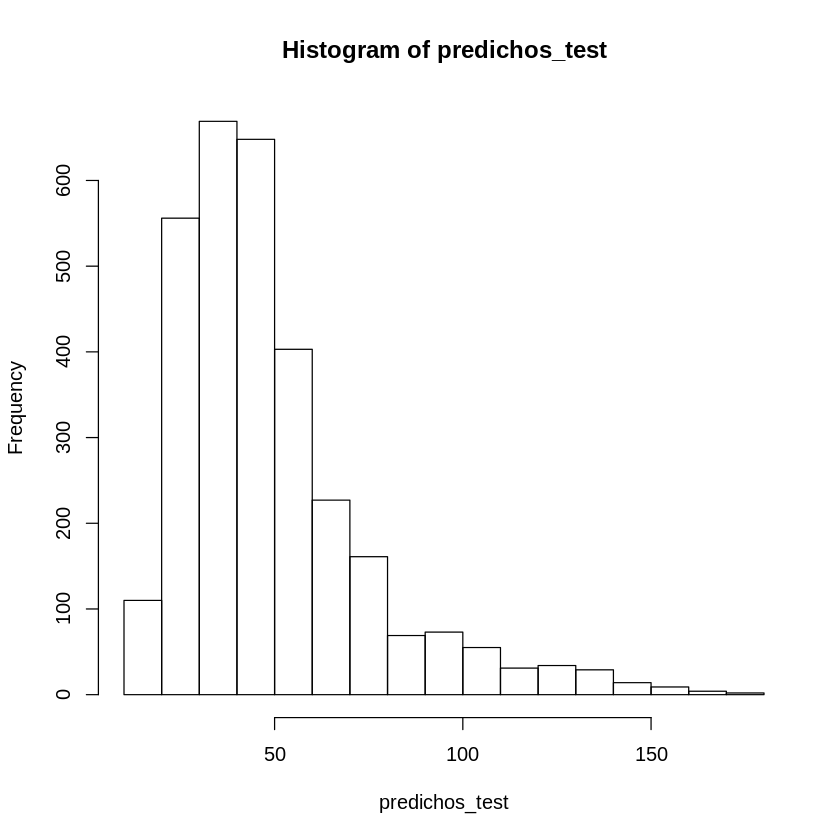

In [38]:
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict) %>% exp()
hist(predichos_test)

  |======================================================================| 100%
  |======================================================================| 100%


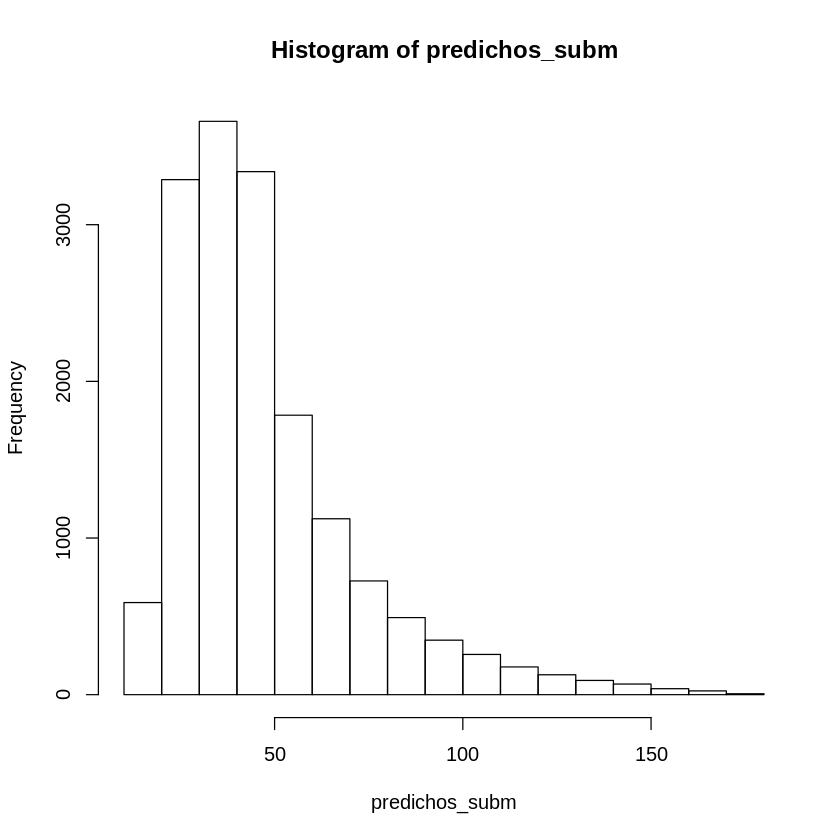

In [39]:
predichos_subm <- h2o.predict(xgb, as.h2o(df_test2)) %>%
  as.data.frame() %>% pull(predict) %>% exp()
hist(predichos_subm)

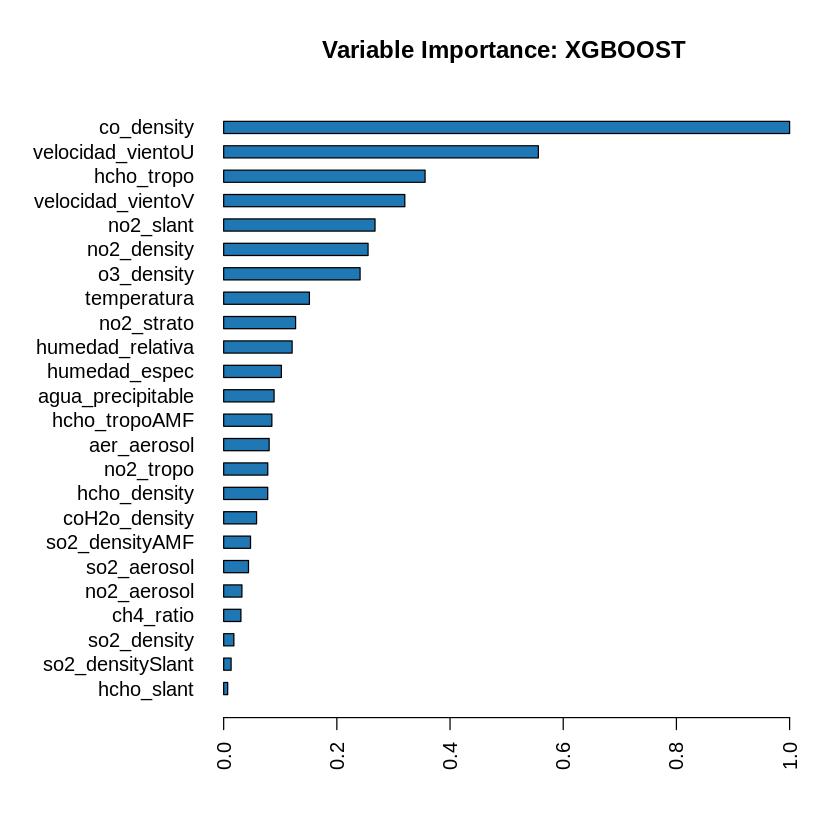

In [47]:
h2o.varimp_plot(xgb, num_of_features = 30)